# [House Prices Predict](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

#### 資料分析的第一步：EDA(exploratory data analysis)

* 預測目的: 問題是屬於 $Regression$ 問題還是 $classification$ 問題，預測房價為多少即是一個 $Regression$ 問題
* 了解問題: 觀察每個特徵的意義，以初步的假設思考是否有助於預測
* 對資料先進行簡單的初步整理
* 建立思考方向: 
    * 從預測值下手: 當房價變化時，哪些特徵有明顯的變化?  (正相關, 負相關, 無相關, 離群值)
    * 從特徵下手: 當某一個特徵變化時，哪些特徵亦有明顯的變化?  (ECDF(empirical distribution function))
* 清楚方向之後，針對特徵進行更進一步的篩選或是處理(例如: 排除無助於預測的特徵、離群值, 轉換類別數據, 特徵轉換)

#### 資料分析的第二步：建立預測模型

* 選擇適當的迴歸模型: 
    * `Linear regression`: 最基礎的迴歸模型，若表現不錯，適合作為一個 $base line$。
    * `Stepwise regression`: 逐步迴歸，遍歷所有特徵。
    * `Ridge regression`: 在`Linear regression`的損失函數上添加`L2`正則項，限制模型複雜度，賦予影響較大的特徵較高的權重係數，針對影響較小的特徵係數`收縮接近0`。
    * `Lasso regression`: 在`Linear regression`的損失函數上添加`L1`正則項，限制模型複雜度，將影響較少的特徵係數`收縮至0`，捨棄影響較少的特徵，進而達到特徵選擇的目的。
    * `Elastic Net Regression`: 在`Linear regression`的損失函數上同時加上`L1`與`L2`，目的同樣是限制模型複雜度。
    * `SVM Regression`: 效率快速且適合作為 $base line$ 的 `linear svm`，以及其他的非線性`kernel`也是不錯的選擇。
    
####  資料分析第三部：模型評估

* 針對迴歸問題，經常使用的評價指標有
    * 平均方差 $mse$ `(mean_squared_error)`
    * 平均絕對誤差 $mae$ `(mean_absolute_error)`
    * 判定係數 $R^2$ `(R-squared)`
    * 矯正判定係數 $R_{adj}^2$

### Data overview

In [58]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#### 房價資料包含了80個特徵，訓練資料數量為1460筆，測試則為1459筆

In [59]:
train = pd.read_csv('all/train.csv',index_col=False)
test = pd.read_csv('all/test.csv')
print('train.shape: ',train.shape)
print('test.shape: ',test.shape)
print(train.columns)
alldata = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                     test.loc[:,'MSSubClass':'SaleCondition']))
alldata = alldata.reset_index(drop=True)

train.shape:  (1460, 81)
test.shape:  (1459, 80)
Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea

#### 統計training data與testing data的缺失值。

In [60]:
misscol = []
for col in alldata.columns:
    if alldata[col].isnull().sum()>0:
        misscol.append(col)
        print(col,":" ,alldata[col].isnull().sum())

MSZoning : 4
LotFrontage : 486
Alley : 2721
Utilities : 2
Exterior1st : 1
Exterior2nd : 1
MasVnrType : 24
MasVnrArea : 23
BsmtQual : 81
BsmtCond : 82
BsmtExposure : 82
BsmtFinType1 : 79
BsmtFinSF1 : 1
BsmtFinType2 : 80
BsmtFinSF2 : 1
BsmtUnfSF : 1
TotalBsmtSF : 1
Electrical : 1
BsmtFullBath : 2
BsmtHalfBath : 2
KitchenQual : 1
Functional : 2
FireplaceQu : 1420
GarageType : 157
GarageYrBlt : 159
GarageFinish : 159
GarageCars : 1
GarageArea : 1
GarageQual : 159
GarageCond : 159
PoolQC : 2909
Fence : 2348
MiscFeature : 2814
SaleType : 1


### 討論有缺失值的欄位：

[所有欄位說明](https://ww2.amstat.org/publications/jse/v19n3/decock/datadocumentation.txt)

---

* `LotFrontage`：土地面向街道的寬度，缺失值補0

![LotFrontage](feature engineer/Lot_map.png)

* `Alley`：巷弄街道類型，Grvl為碎石路面，Pave為石塊路面，其中`NaN`有1369筆 ，數量過多，使用`missing`來代替

---

* `MasVnrType`：砌體結構類型，其中`None`有864筆，`NaN`有8筆，`NaN`以`None`來代替

* `MasVnrArea`：砌體面積，其中有861筆為0，`NaN`有8筆，`NaN`補`0`

---

* `BsmtQual`：地下室的高度，使用`TA,Gd,Ex,Fa`來表示高低程度，`NaN`有37筆，使用數量最多的`TA`代替

* `BsmtCond`：地下室的一般狀況，使用`TA,Gd,Fa,Po`來表示程度，`NaN`有37筆，使用數量最多的`TA`代替

* `BsmtExposure`：地下室牆壁，使用`No,Av,Gd,Mn`來表示，其中`NaN`有38筆，使用數量最多的`No`代替

* `BsmtFinType1`：地下室完工面積的品質，以`Unf,GLQ,ALQ,BLQ,Rec,LwQ`表示，`Nan`有37筆，使用數量最多的`Unf`來代替

* `BsmtFinType2`：地下室第二區域完成面積品質，類別表示同上，欄位說明中最後表示(if present)，`NaN`有38筆，使用數量最多的`Unf`來代替

---

* `Electrical`：供電系統，以`SBrkr,FuseA,FuseF,FuseP,Mix`表示，`NaN`只有1筆，使用數量最多的`SBrkr`代替

* `FireplaceQu`：壁爐品質，以`Gd,TA,Fa,Ex,Po`表示，`Nan`數量最多共有690筆，使用`missing`代替

---

* `GarageType`：車庫位置，`NaN`共有81筆，使用數量最多的`Attchd`代替

* `GarageYrBlt`：建立車庫的年份，`NaN`數量最多有81筆，其餘年份零零散散，從1933年至2005年數量呈現遞增，考慮不使用這個欄位

* `GarageFinish`：車庫完工程度，以`Unf,RFn,Fin`表示，`NaN`共有81筆，使用數量最多`Unf`來代替

* `GarageQual`：車庫品質，以`TA,Fa,Gd,Po,Ex`表示，`NaN`有81筆，使用數量最多`TA`來代替

* `GarageCond`: 車庫條件，以`TA,Fa,Gd,Po,Ex`表示，`NaN`有81筆，使用數量最多`TA`代替

---

* `PoolQC`：游泳池品質，以`Gd,Ex,Fa`表示，`NaN`數量最多，共有1453筆，使用`missing`代替

* `Fence`：柵欄品質，以`MnPrv,GdPrv,GdWo,MnWw`表示，`NaN`數量最多，共有1179筆，使用`missing`代替

* `MiscFeature`：其餘的冗余特徵，以`Shed,Gar2,Othr,TenC`表示，`NaN`數量最多，有1406筆，使用`missing`代替

---

以上是針對欄位缺失值的處理，其中有些欄位的缺失值數量是相近或是一模一樣的，例如`Bsmt`開頭的欄位，數量皆在37~38筆，檢查會發現其實這五個欄位其實是同一筆資料，針對同一筆資料會傾向於使用同一種處理缺失值的方式，例如將`NaN`使用數量最多的`TA`來代替。

另外，`Garage`開頭的欄位，數量全部都是81筆，檢查發現這81筆其實也是同一筆資料，傾向於使用同一種處理方式，例如將`NaN`使用數量最多的`Unf`來代替。

也許有人會思考說，如果含有`NaN`的欄位都是來自同一筆資料，那只要把那筆資料拿掉就好啦？我這裡選擇不拿掉的原因是因為訓練資料只有1460筆，因為資料量實在太少了，所以想盡量保留資料裡面的訊息。

### 檢查欄位各類別數量的方式，替換欄位部分即可

In [61]:
alldata['Exterior1st'].value_counts(dropna=False)

VinylSd    1025
MetalSd     450
HdBoard     442
Wd Sdng     411
Plywood     221
CemntBd     126
BrkFace      87
WdShing      56
AsbShng      44
Stucco       43
BrkComm       6
AsphShn       2
Stone         2
CBlock        2
ImStucc       1
NaN           1
Name: Exterior1st, dtype: int64

### 檢查具有同樣名稱開頭欄位的`NaN`是否來是同一筆資料

In [62]:
alldata[alldata.GarageType.isnull()].loc[:,['GarageType','GarageYrBlt','GarageFinish','GarageQual']]

,GarageType,GarageYrBlt,GarageFinish,GarageQual
39,NaN,NaN,NaN,NaN
48,NaN,NaN,NaN,NaN
78,NaN,NaN,NaN,NaN
88,NaN,NaN,NaN,NaN
89,NaN,NaN,NaN,NaN
99,NaN,NaN,NaN,NaN
108,NaN,NaN,NaN,NaN
125,NaN,NaN,NaN,NaN
127,NaN,NaN,NaN,NaN
140,NaN,NaN,NaN,NaN


### 定義處理缺失值函數

In [63]:
def fill_nan(data):
    data['LotFrontage'] = data['LotFrontage'].fillna(0)
    data['Alley'] = data['Alley'].fillna('missing')
    data['MasVnrType'] = data['MasVnrType'].fillna('None')
    data['MasVnrArea'] = data['MasVnrArea'].fillna(0)
    data['BsmtQual'] = data['BsmtQual'].fillna('TA')
    data['BsmtCond'] = data['BsmtCond'].fillna('TA')
    data['BsmtExposure'] = data['BsmtExposure'].fillna('No')
    data['BsmtFinType1'] = data['BsmtFinType1'].fillna('Unf')
    data['BsmtFinType2'] = data.fillna('Unf')
    data['Electrical'] = data['Electrical'].fillna('SBrkr')
    data['FireplaceQu'] = data['FireplaceQu'].fillna('missing')
    data['GarageType'] = data['GarageType'].fillna('Attchd')
    data = data.drop('GarageYrBlt', axis=1)
    data['GarageFinish'] = data['GarageFinish'].fillna('Unf')
    data['GarageQual'] = data['GarageQual'].fillna('TA')
    data['GarageCond'] = data['GarageCond'].fillna('TA')
    data['PoolQC'] = data['PoolQC'].fillna('missing')
    data['Fence'] = data['Fence'].fillna('missing')
    data['MiscFeature'] = data['MiscFeature'].fillna('missing')
    data['MSZoning'] = data['MSZoning'].fillna(data['MSZoning'].mode()[0]) # 針對數量極少的NaN，直接使用眾數來代替
    data['Utilities'] = data['Utilities'].fillna(data['Utilities'].mode()[0])
    data['Exterior1st'] = data['Exterior1st'].fillna(data['Exterior1st'].mode()[0])
    data['Exterior2nd'] = data['Exterior2nd'].fillna(data['Exterior2nd'].mode()[0])
    data['BsmtFinSF1'] = data['BsmtFinSF1'].fillna(data['BsmtFinSF1'].mode()[0])
    data['BsmtFinSF2'] = data['BsmtFinSF2'].fillna(data['BsmtFinSF2'].mode()[0])
    data['BsmtUnfSF'] = data['BsmtUnfSF'].fillna(data['BsmtUnfSF'].mode()[0])
    data['TotalBsmtSF'] = data['TotalBsmtSF'].fillna(data['TotalBsmtSF'].mode()[0])
    data['BsmtFullBath'] = data['BsmtFullBath'].fillna(data['BsmtFullBath'].mode()[0])
    data['BsmtHalfBath'] = data['BsmtHalfBath'].fillna(data['BsmtHalfBath'].mode()[0])
    data['KitchenQual'] = data['KitchenQual'].fillna(data['KitchenQual'].mode()[0])
    data['Functional'] = data['Functional'].fillna(data['Functional'].mode()[0])
    data['GarageCars'] = data['GarageCars'].fillna(data['GarageCars'].mode()[0])
    data['GarageArea'] = data['GarageArea'].fillna(data['GarageArea'].mode()[0])
    data['SaleType'] = data['SaleType'].fillna(data['SaleType'].mode()[0])

    return data

In [64]:
alldata = fill_nan(alldata)
print('處理完後NaN數量:',alldata.isnull().any().sum())

處理完後NaN數量: 0


### 處理完`NaN`之後，我們來觀察欄位名稱是否有一些訊息

In [65]:
print(alldata.columns)

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'Ope

#### 有些欄位有一些規律，像是針對一個物件的條件、品質、質量、面積等等進行評價，而且透過上方處理`NaN`時發現，某些欄位評價的評級其實是相同的，例如說`GarageQual`以及`GarageCond`的評級都是`TA,Fa,Gd,Po,Ex`，現在我們來統計有同樣評級的欄位有哪些，還有可以用程度表示的欄位有哪些。

In [66]:
categorical = [col for col in alldata.columns if train[col].dtype == 'O']
for i in categorical:
    print(i,':',alldata[i].unique())

MSZoning : ['RL' 'RM' 'C (all)' 'FV' 'RH']
Street : ['Pave' 'Grvl']
Alley : ['missing' 'Grvl' 'Pave']
LotShape : ['Reg' 'IR1' 'IR2' 'IR3']
LandContour : ['Lvl' 'Bnk' 'Low' 'HLS']
Utilities : ['AllPub' 'NoSeWa']
LotConfig : ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
LandSlope : ['Gtl' 'Mod' 'Sev']
Neighborhood : ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
Condition1 : ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
Condition2 : ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
BldgType : ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
HouseStyle : ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
RoofStyle : ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']
RoofMatl : ['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran' 'Tar&Grv' 'Roll'
 'ClyTil

### 接下來花一點功夫整理，我們針對有意義的各個欄位評級給予一個數值，可以透過這份[說明文件](https://ww2.amstat.org/publications/jse/v19n3/decock/datadocumentation.txt)作為依據

* `Street,Alley`：`['missing' 'Grvl' 'Pave']`

* `LandSlope`：`['Gtl' 'Mod' 'Sev']`

* `HouseStyle`：`['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']`

* `ExterQual,ExterCond,BsmtQual,BsmtCond,HeatingQC,KitchenQual,FireplaceQu,GarageQual,GarageCond,PoolQC`：`['EX' 'Gd' 'TA' 'Fa' 'Po' ]`

* `Foundation`：`['PConc' 'CBlock' 'BrkTil' 'Wood' 'Slab' 'Stone']`

* `BsmtExposure`：`['No' 'Gd' 'Mn' 'Av']`

* `BsmtFinType1,BsmtFinType2`：`['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' 'LwQ']`

* `CentralAir`：`['Y' 'N']`

* `Functional`：`['Typ' 'Min1' 'Maj1' 'Min2' 'Mod' 'Maj2' 'Sev']`

* `GarageFinish`：`['RFn' 'Unf' 'Fin']`

* `PavedDrive`：`['Y' 'N' 'P']`

* `Fence`：`['missing' 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']`

---

* `MSSubClass`：`[ 60,  20,  70,  50, 190,  45,  90, 120,  30,  85,  80, 160,  75, 180,  40, 150]`

* `OverallQual`：`[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]`

* `OverallCond`：`[1, 2, 3, 4, 5, 6, 7, 8, 9]`

In [67]:
from sklearn.preprocessing import LabelEncoder
alldata['MSSubClass'] = alldata['MSSubClass'].astype(str)
alldata['OverallQual'] = alldata['OverallQual'].astype(str)
alldata['OverallCond'] = alldata['OverallCond'].astype(str)
alldata['YearRemodAdd'] = alldata['YearRemodAdd'].astype(str)
alldata['MoSold'] = alldata['MoSold'].astype(str)
cols = ['Street','Alley','LandSlope','HouseStyle','ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual',
        'FireplaceQu','GarageQual','GarageCond','PoolQC','Foundation','BsmtExposure','BsmtFinType1','BsmtFinType2','CentralAir',
        'Functional','GarageFinish','PavedDrive','Fence','MSSubClass','OverallQual','OverallCond','YearRemodAdd','MoSold','Heating']

for col in cols:
    lbender = LabelEncoder() 
    lbender.fit(list(alldata[col].values)) 
    alldata[col] = lbender.transform(list(alldata[col].values))

### 從數值型的欄位觀察，是否有我們認為不需要的欄位或是能夠互相interate的欄位。
* `MSSubClass`：建築類型。
* `YearBuilt`：建築施工日期。
* `YearRemodAdd`：建築整修日期，如果沒有整修就與`YearBuilt`一樣。
* `BsmtFinType1,BsmtFinType1`：皆為地下室竣工面積品質。
* `BsmtFinSF1,BsmtFinSF2`：皆為地下室竣工面積。
* `TotalBsmtSF,1stFlrSF,2ndFlrSF`：地下室總面積、一樓及二樓面積。
* `BsmtFullBath,BsmtHalfBath,FullBath,HalfBath`：地下室浴室數量,地面以上的浴室數量。
* `OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch`：皆是門廊的面積。
* `MiscVal`：雜項特徵的值，與`MiscFeature`一樣。
* `MoSold`：銷售月份。
* `YrSold`：銷售年份，可以與上面的`YearBuilt`結合，得到房屋銷售時的屋齡。

In [68]:
def numerical_proc(data):
    data['BsmtFinType'] = data['BsmtFinType1'] + data['BsmtFinType2']
    data['BsmtFinSF'] = data['BsmtFinSF1'] + data['BsmtFinSF2']
    data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']
    data['Bath'] = data['BsmtFullBath'] + data['BsmtHalfBath'] + data['FullBath'] + data['HalfBath']
    data['Porch'] = data['OpenPorchSF'] + data['EnclosedPorch'] + data['3SsnPorch'] + data['ScreenPorch']
    data['BuildingAge'] = data['YrSold'] - data['YearBuilt']
    return data

alldata = numerical_proc(alldata)

### 得到屋齡後，將`YrSold`及`YearBuilt`轉成`label encoder`

In [69]:
alldata['YrSold'] = alldata['YrSold'].astype(str)
alldata['YearBuilt'] = alldata['YearBuilt'].astype(str)
cols = ['YrSold','YearBuilt']
for col in cols:
    lbender = LabelEncoder() 
    lbender.fit(list(alldata[col].values)) 
    alldata[col] = lbender.transform(list(alldata[col].values))

### 現在我們大致完成了所有欄位的處理，接下來從訓練資料中的房價作為解釋變數下手，觀察每個特徵對房價的相關性，將分成連續型與離散型。

* 連續型數值：例如`GarageArea`車庫面積就是個連續型數值，我們期望看到當面積越大，房價也越高的情況。

* 離散型數值：例如`OverallQual`房屋材料與質量是以等級來區分，總共1~10級，我們期望看到當數值等級越高時，房價也越高的情況

---

### 針對連續型變數，適合使用散佈圖來觀察趨勢

從中發現，大部分的散佈圖當 $x$ 軸數值越來越大時，房價的確是越來越高，但是離群值也越來越多，當遇到這種情況時，我們考慮使用對數轉換，減少離群值對整體資料的影響。

這裏需要另外注意，屋齡`BuildingAge`是負相關，這是因為屋齡越老房價越便宜，負相關對於迴歸預測也是有幫助的，這個欄位需要保留。

In [70]:
continuous = ['LotFrontage','LotArea','MasVnrArea','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','BsmtFinSF1','ScreenPorch','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','BsmtFinSF','2ndFlrSF','TotalSF','LowQualFinSF','GrLivArea','Porch','BuildingAge']

In [71]:
plotdd = alldata[:train.shape[0]]
plotdd['SalePrice'] = train.SalePrice

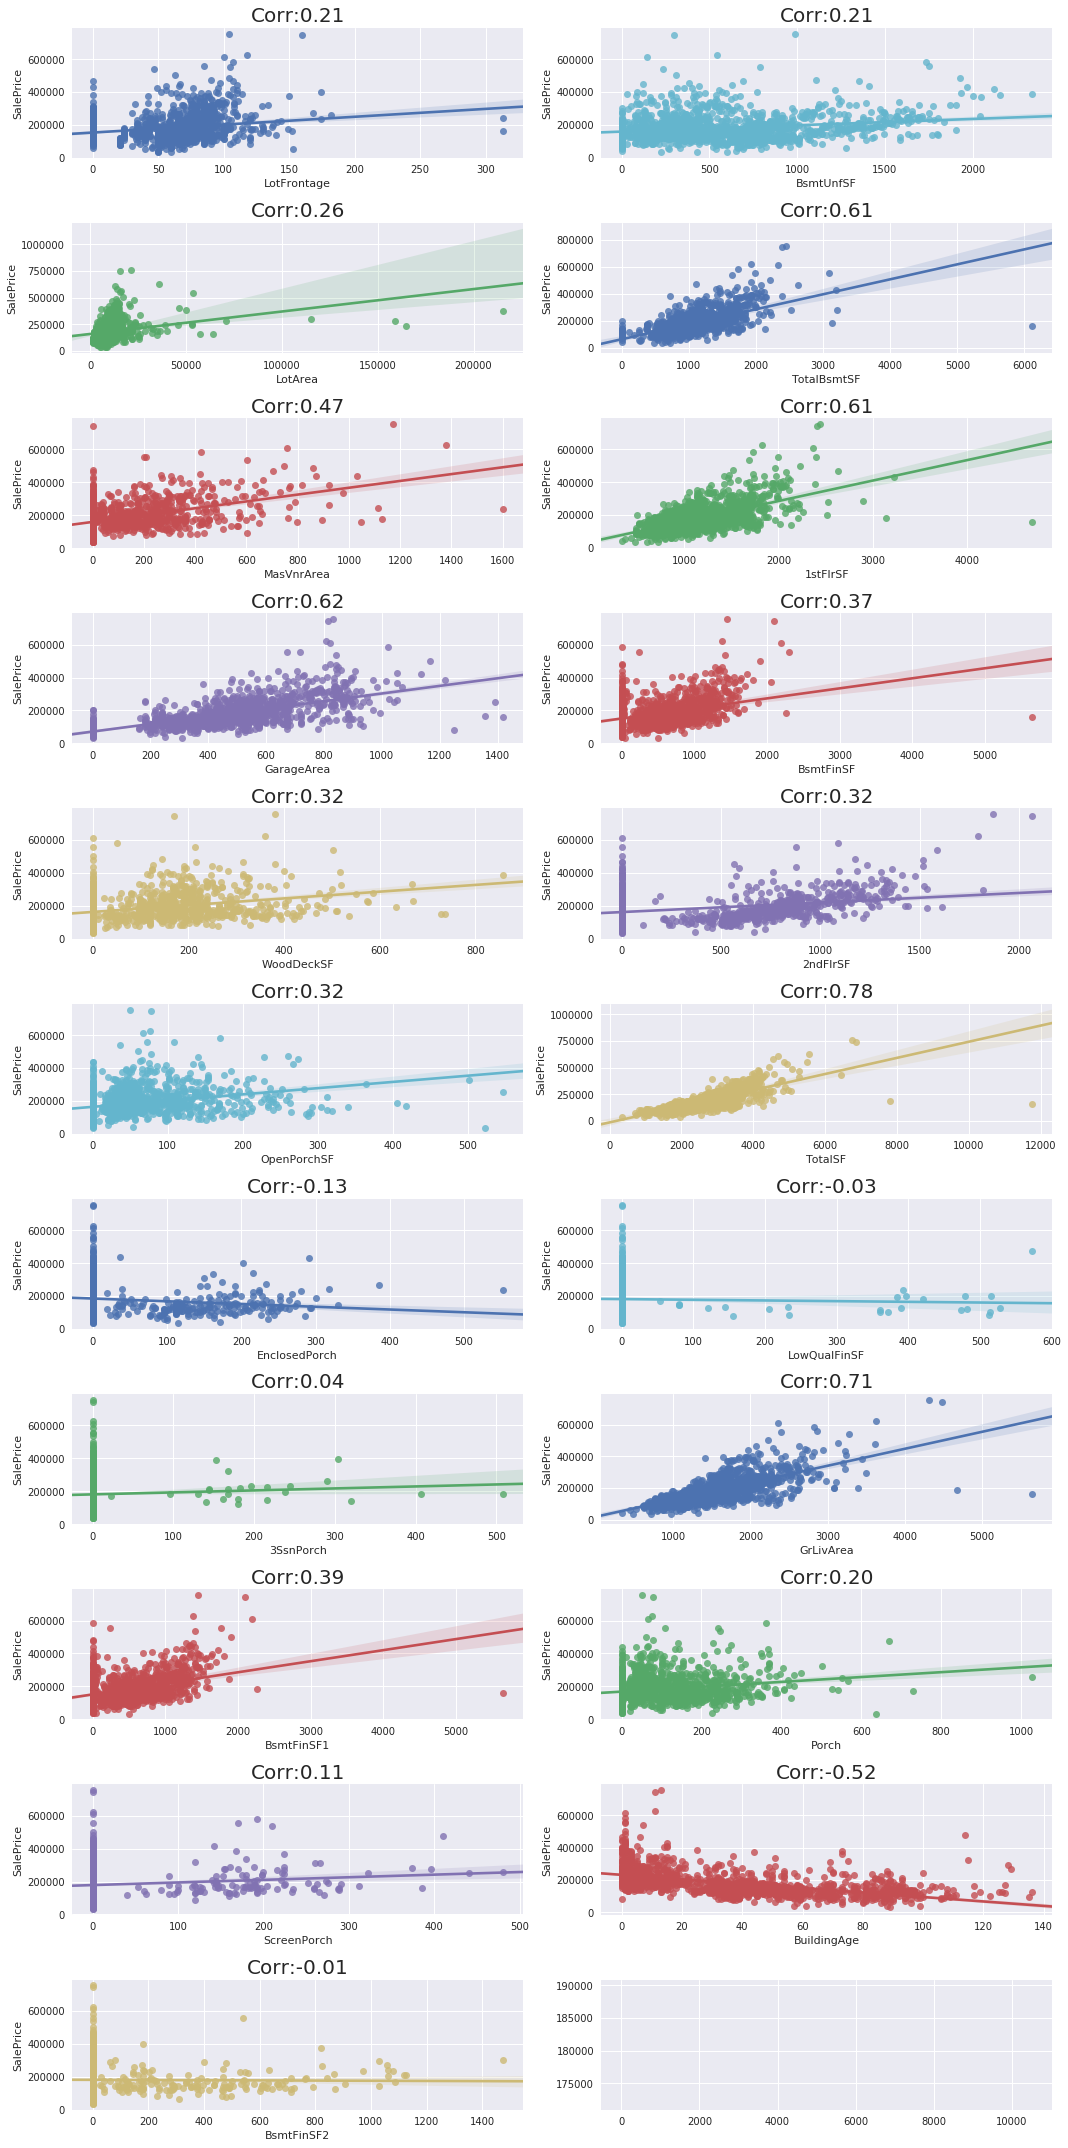

In [72]:
rcParams['figure.figsize'] = (15,30)
fig, axes = plt.subplots(11,2)
sns.set(color_codes=True)
for i in range(len(continuous)):
    if i < 11:
        pp = sns.regplot(data=plotdd, x=continuous[i], y='SalePrice', ax=axes[i,0])
        pp.set_title('Corr:%.2f' % np.corrcoef(plotdd['SalePrice'],plotdd[continuous[i]])[0,1],size=20)
    else:
        pp2 = sns.regplot(data=plotdd, x=continuous[i], y='SalePrice', ax=axes[i-11,1])
        pp2.set_title('Corr:%.2f' % np.corrcoef(plotdd['SalePrice'],plotdd[continuous[i]])[0,1],size=20)
    plt.tight_layout()

### 接下來，決定把離群值剔除。

In [73]:
#alldata = alldata.drop(plotdd[(plotdd['TotalBsmtSF']>5000) & (plotdd['SalePrice']<300000)].index)
#alldata = alldata.drop(plotdd[(plotdd['1stFlrSF']>4000) & (plotdd['SalePrice']<300000)].index)
#alldata = alldata.drop(plotdd[(plotdd['BsmtFinSF']>5000) & (plotdd['SalePrice']<300000)].index)
#alldata = alldata.drop(plotdd[(plotdd['TotalSF']>10000) & (plotdd['SalePrice']<300000)].index)
# 這裏發現離群值其實都是同一筆，而GrLivArea的離群值多一筆
alldata = alldata.drop(plotdd[(plotdd['GrLivArea']>4000) & (plotdd['SalePrice']<300000)].index)
y = train['SalePrice'].drop(plotdd[(plotdd['GrLivArea']>4000) & (plotdd['SalePrice']<300000)].index)

plotdd = plotdd.drop(plotdd[(plotdd['GrLivArea']>4000) & (plotdd['SalePrice']<300000)].index)
#alldata = alldata.drop(plotdd[(plotdd['BsmtFinSF1']>5000) & (plotdd['SalePrice']<300000)].index)

### 針對離散型變數，適合使用盒鬚圖

前面我們已經針對評級進行數值轉換，所以現在的`x軸`由左至右是具有大小優劣程度之分，例如`OverallQual`隨著評分越高，房價是跟著上升的，所以我們可以透過這樣的方式，來判斷哪些欄位是我們感興趣的。

* `PavedDrive,Functional,CentralAir,BsmtExposure,Alley,GarageFinish,BsmtFinType2,FullBath,OverallCond,BsmtCond,BsmtFinType,Fireplaces`

以上欄位是透過以下盒鬚圖篩選而來的，其中有一個欄位是`YearBuilt`房屋建造的年份，這個欄位在趨勢上的確是隨著越接近現代，房價越高，但是我不認為這是一種能夠使用的特徵，因為如果我是買家，我不會在意我現在買的年份是什麼時候，我只會對`物件`方面感興趣，例如說`GarageFinish`車庫完成質量。而會造成年份越接近現代房價越高的現象我想可能是通貨膨脹。

其中，`LandSlope`表示房屋位置的土地坡度傾斜程度，盒鬚圖表示當坡度越平緩，房價會越便宜，雖然這違反直覺，但是我相信這是有可能的，因為波士頓地理位置靠海，地形起伏不大，而坡度傾斜程度高的地方可能是山丘、高地，數量相對稀少，物以稀為貴，能夠有一個地方可以眺望大海是非常稀少的，所以我認為資料這樣表示是合理的。

In [74]:
discrete1 = ['PavedDrive','Functional','CentralAir','BsmtExposure','Alley','GarageFinish','BsmtFinType2','FullBath','OverallCond','BsmtCond','BsmtFinType','Fireplaces']

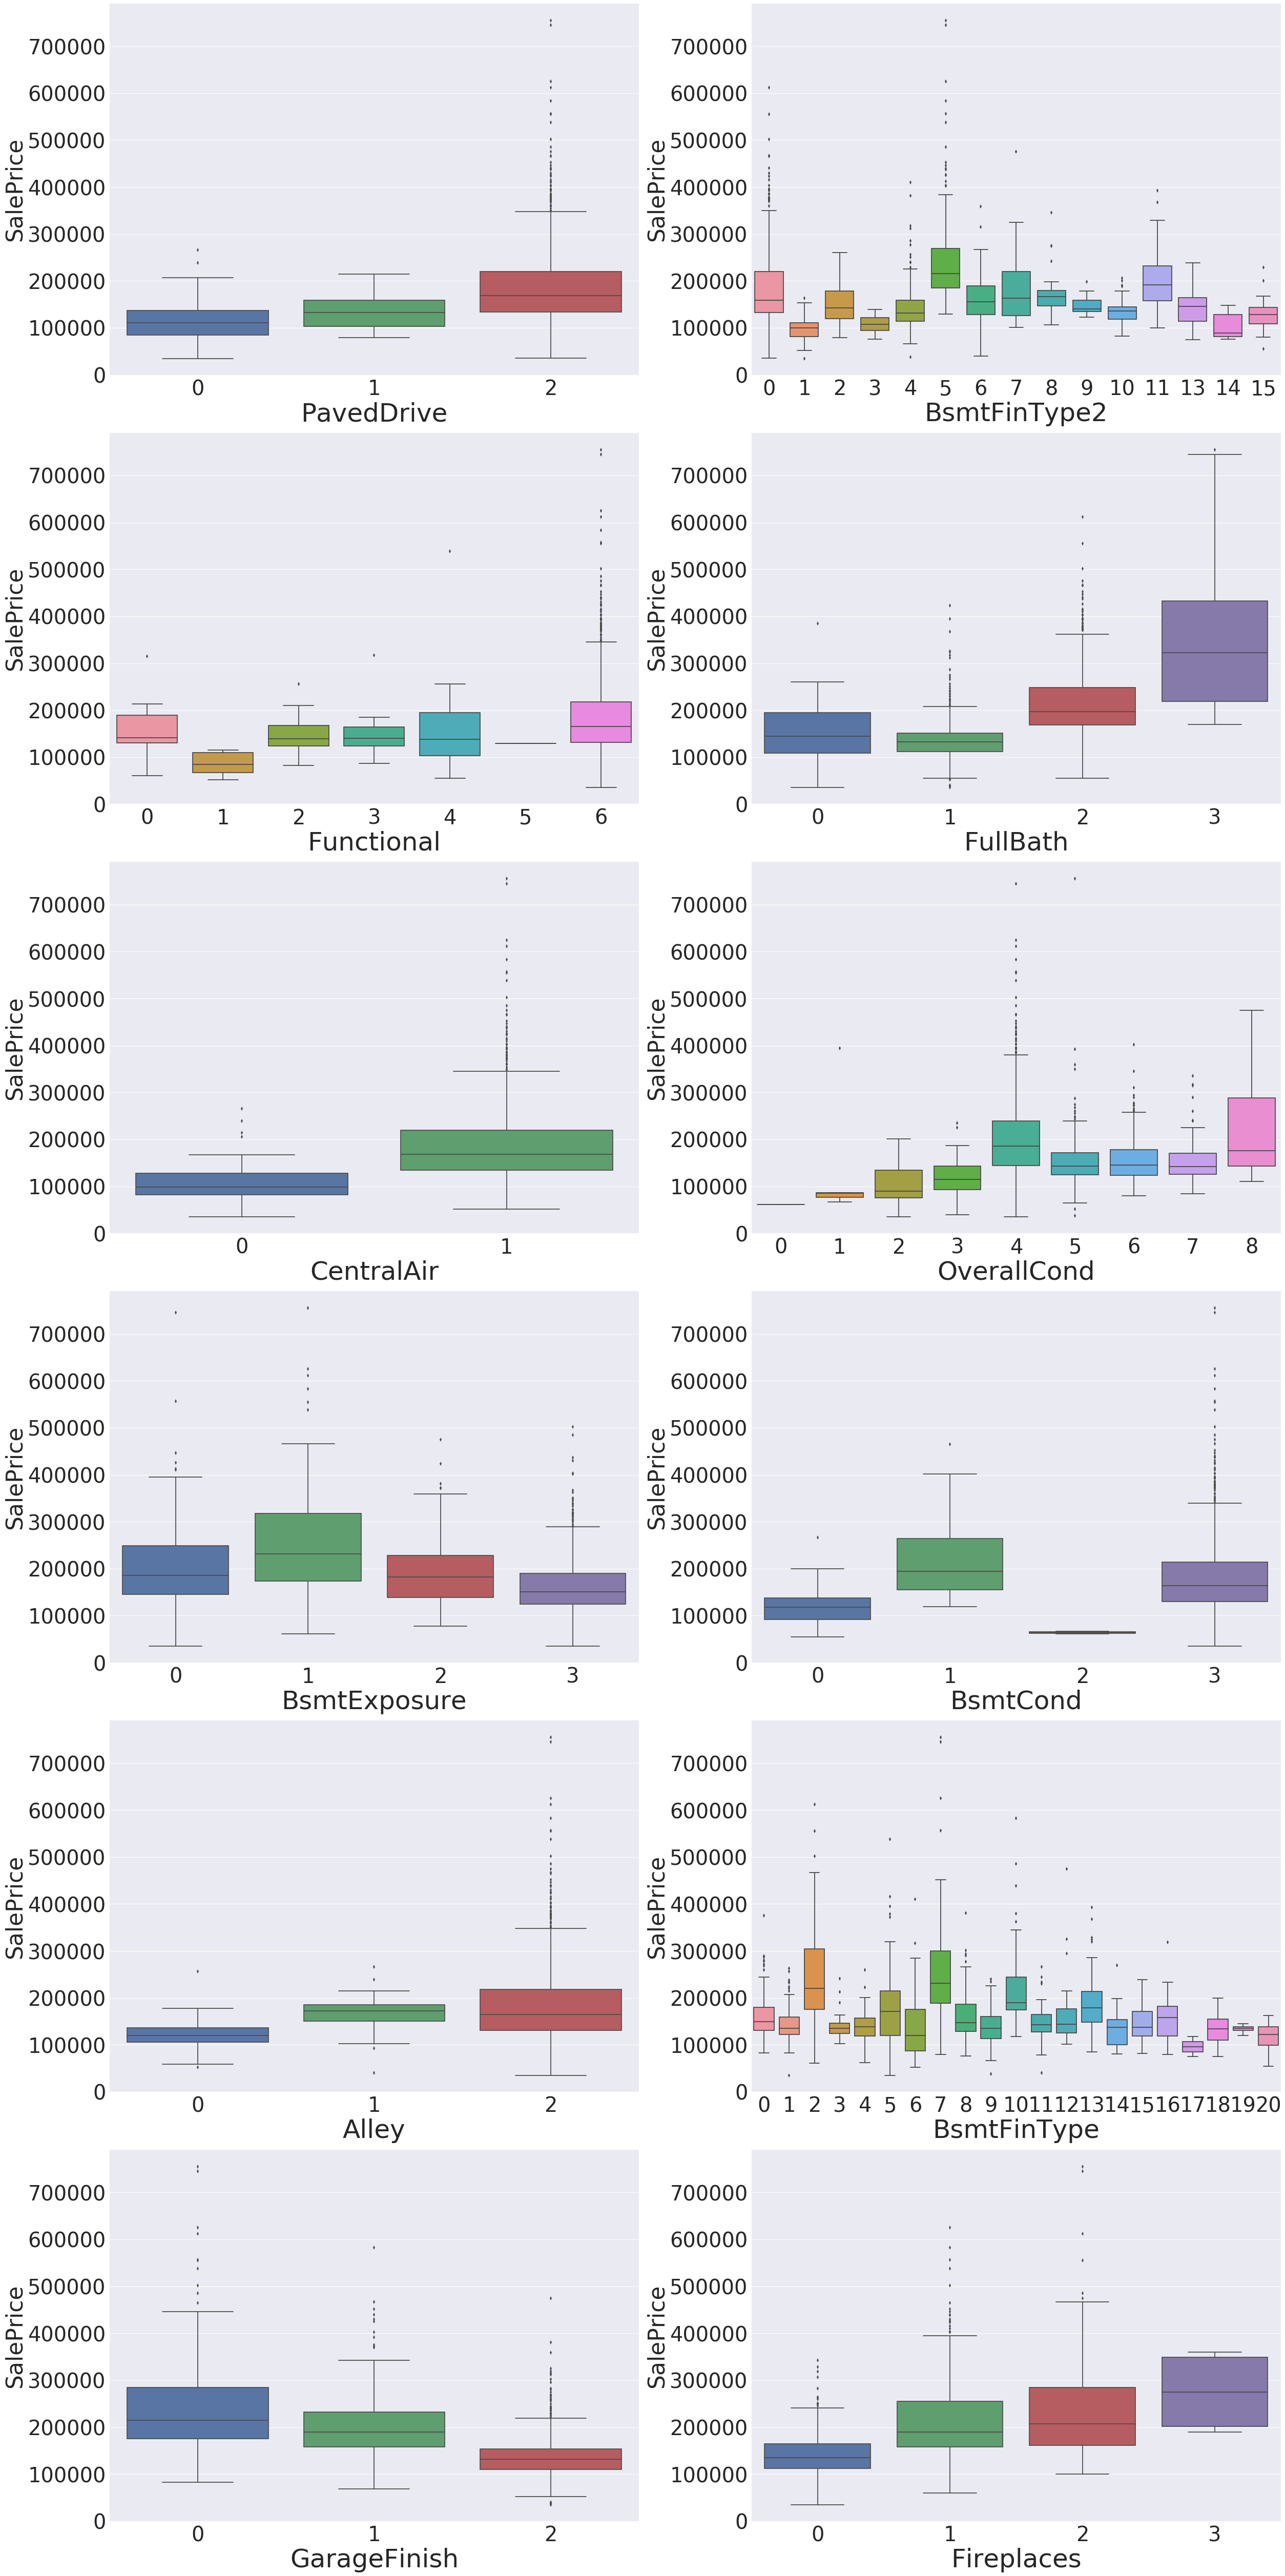

In [75]:
sns.set(font_scale=4)
rcParams['figure.figsize'] = (35,70)
fig, axes = plt.subplots(6,2)
sns.set(color_codes=True)
for i in range(len(discrete1)):
    if i < 6:
        pp = sns.boxplot(data=plotdd, x=discrete1[i], y='SalePrice', ax=axes[i,0])
        pp.set_xlabel(discrete1[i],fontsize=50)
    else:
        pp2 = sns.boxplot(data=plotdd, x=discrete1[i], y='SalePrice', ax=axes[i-6,1])
        pp2.set_xlabel(discrete1[i],fontsize=50)
    plt.tight_layout()

#### 接下來討論其餘欄位

`Street,GarageCond,BsmtFinType1,GarageCars,ExterQual,TotRmsAbvGrd,OverallQual,BsmtQual`
`KitchenQual,Bath,FireplaceQu,GarageQual,BsmtFullBath,HeatingQC`

以上欄位是我覺得當評價變動時，房價確實有上升的欄位，其中`ExterQual,BsmtQual,KitchenQual,HeatingQC`在評級最低時房價卻是比其他評級還要高，這我並不曉得具體原因，我想可能是大部分買家在買房時不會特別在意`材料,地下室,廚房,供熱`的品質，但是到了後面`2,3,4`評級時，房價就有明顯的上升趨勢，也許只有少部分買家對於這三物件特別感興趣。

In [76]:
discrete2 = ['Street','GarageCond','BsmtFinType1','GarageCars','ExterQual','TotRmsAbvGrd','OverallQual','BsmtQual','KitchenQual','Bath','FireplaceQu','GarageQual','BsmtFullBath','HeatingQC']

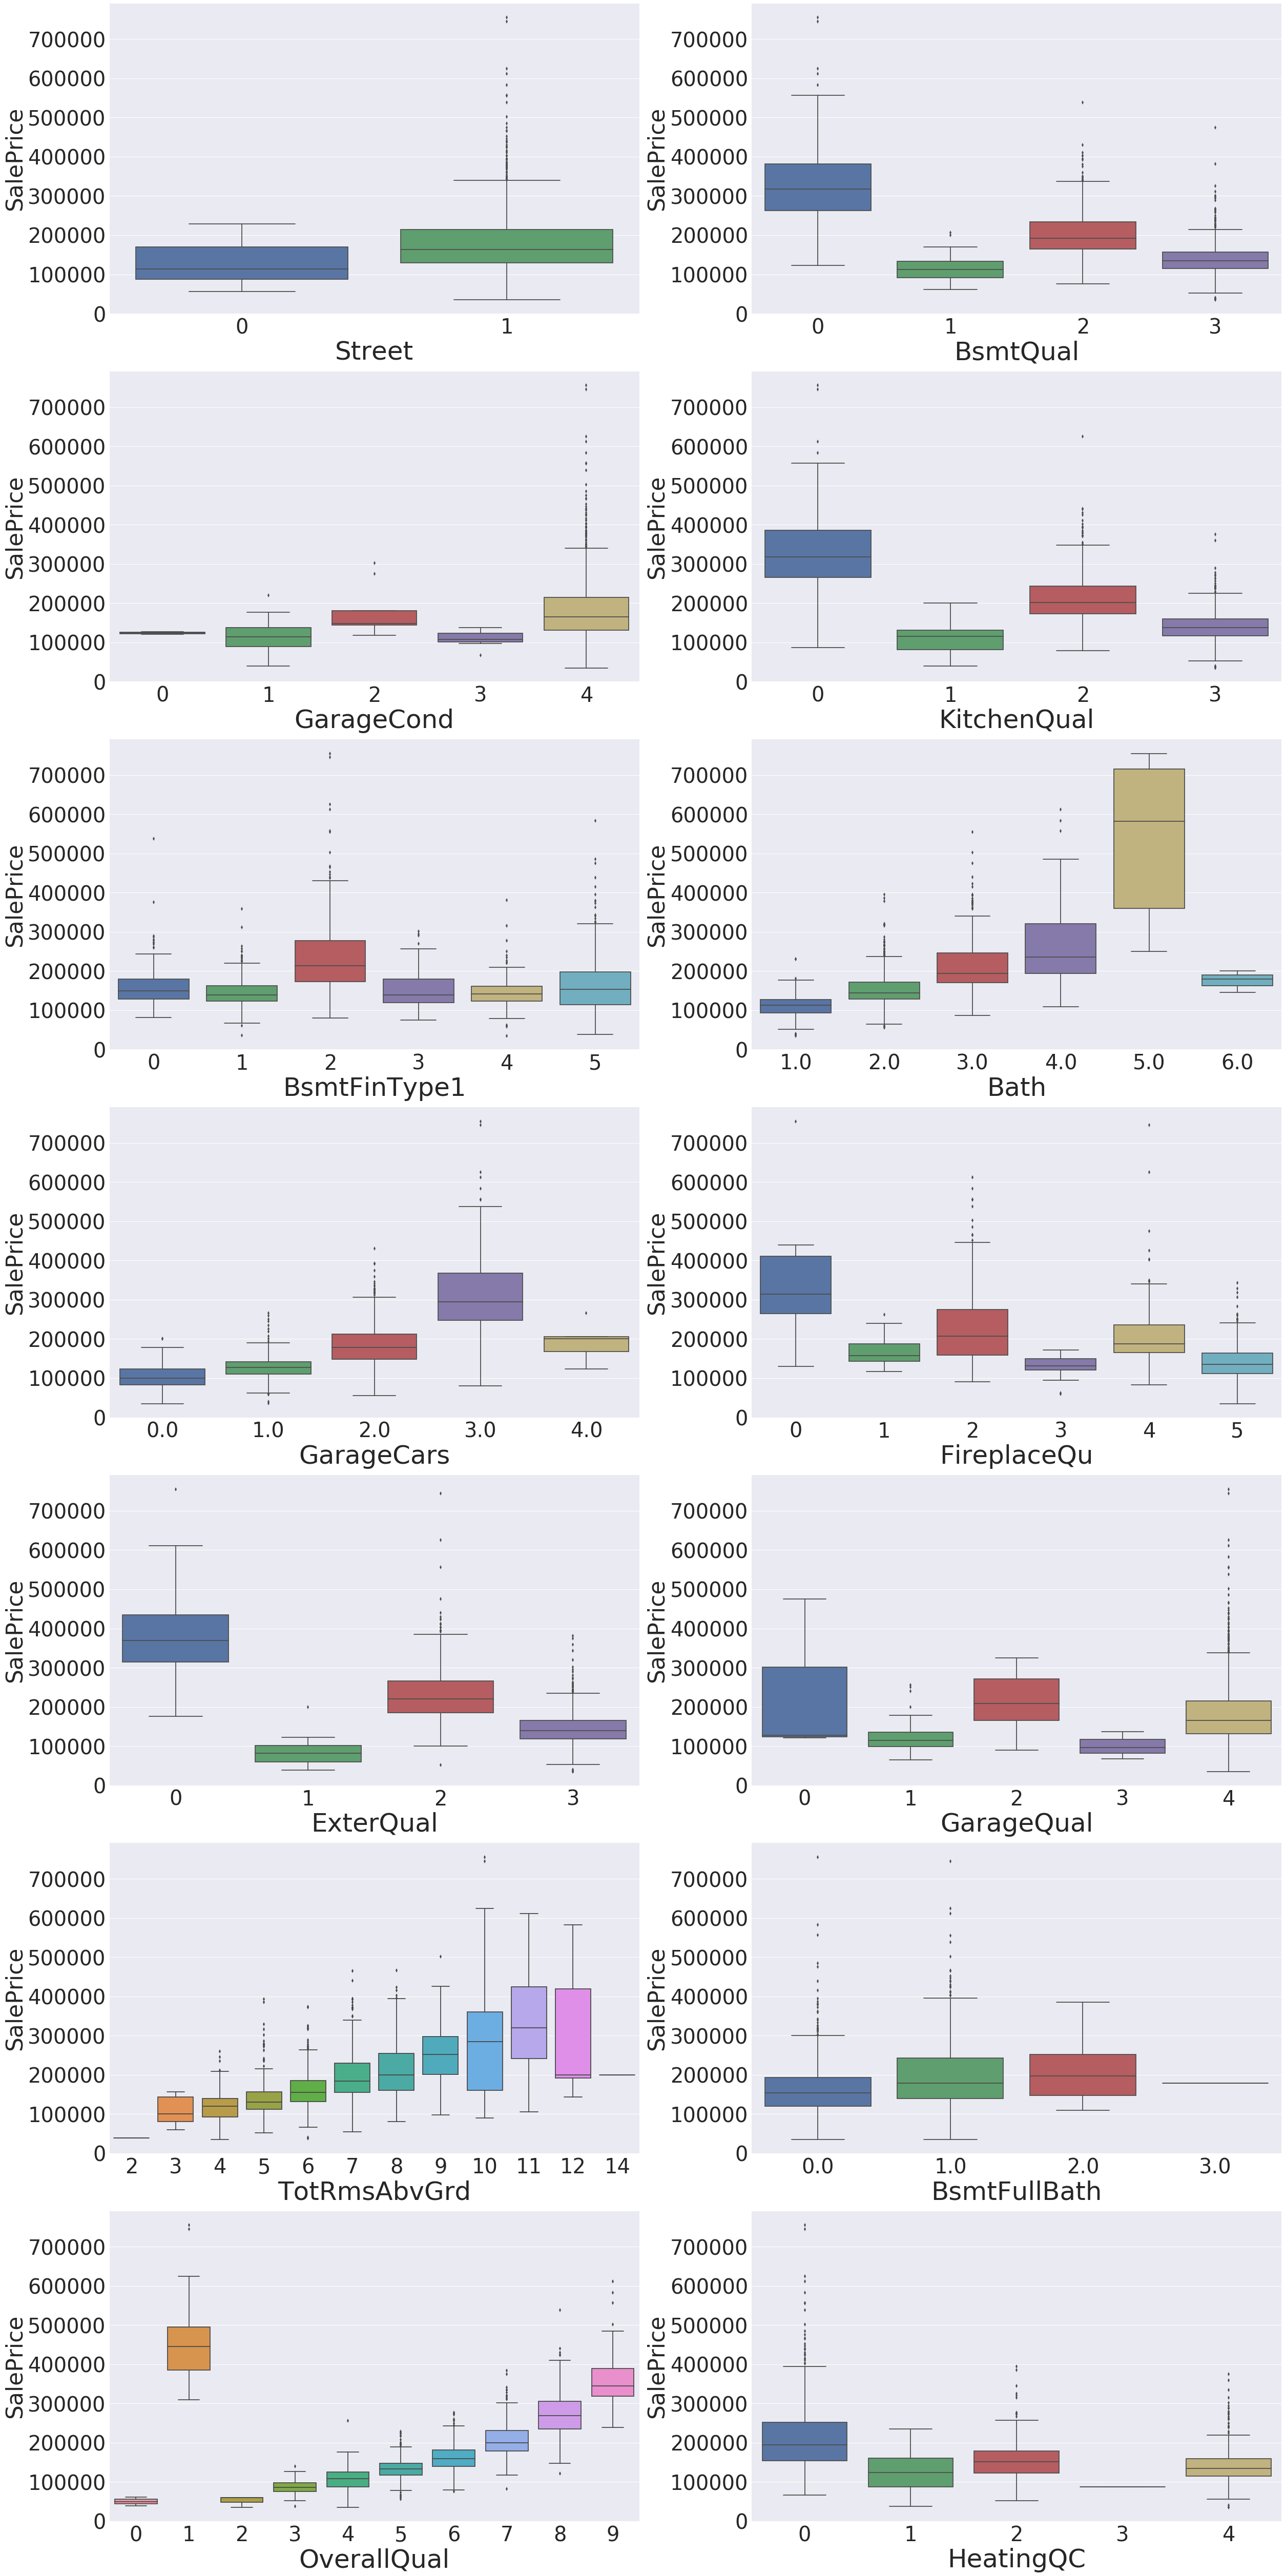

In [77]:
sns.set(font_scale=4)
rcParams['figure.figsize'] = (35,70)
fig, axes = plt.subplots(7,2)
sns.set(color_codes=True)
for i in range(len(discrete2)):
    if i < 7:
        pp = sns.boxplot(data=plotdd, x=discrete2[i], y='SalePrice', ax=axes[i,0])
        pp.set_xlabel(discrete2[i],fontsize=50)
    else:
        pp2 = sns.boxplot(data=plotdd, x=discrete2[i], y='SalePrice', ax=axes[i-7,1])
        pp2.set_xlabel(discrete2[i],fontsize=50)
    plt.tight_layout()

In [85]:
# unuse = ['BsmtHalfBath','GarageQual','KitchenAbvGr','HalfBath','Exterior2nd','BsmtFinType1','Condition1','MSZoning',
#          'Neighborhood','RoofMatl','Fence','Exterior1st','YrSold','Utilities','Heating','YearBuilt','MSSubClass','Condition2',
#          'PoolArea','BldgType','ExterCond','PoolQC','YearRemodAdd','MiscVal','MoSold','BsmtFinType']
# alldata = alldata.drop(unuse, axis=1)

## 接下來，我們要對數值做對數轉換

### 為何要進行對數轉換？

對數轉換的目的是為了減少數值差距過大及離群值而帶來的影響，從`絕對差異`轉變為`相對差異`，使得因變量的方差(離散程度)穩定。

另外一個原因是為了配合統計上各項指標的需求，左圖是未經過對數轉換的散佈圖，右圖是針對`x軸`及`y軸`進行對數轉換的圖，我們發現經過對數轉換後的相關性有提升，這是因為`Pearson`相關係數檢驗的是變量間的`線性關係`，我們能夠透過對數轉換以方便用線性方程式表示模型。

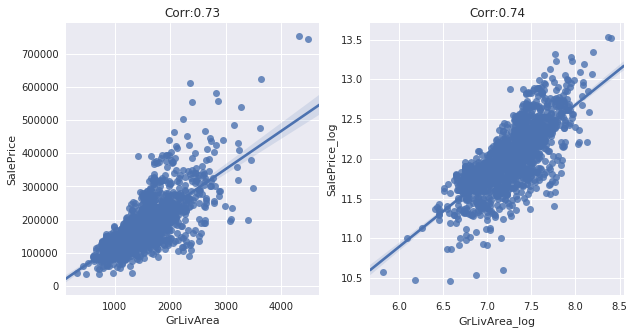

In [78]:
example = plotdd.copy()
example['SalePrice_log'] = np.log1p(example['SalePrice'])
example['GrLivArea_log'] = np.log1p(example['GrLivArea'])

sns.set()
rcParams['figure.figsize'] = (10,5)
plt.subplot(1,2,1)
pp = sns.regplot(x='GrLivArea',y='SalePrice',data=example)
pp.set_title('Corr:%.2f' % np.corrcoef(example['SalePrice'],example['GrLivArea'])[0,1])

plt.subplot(1,2,2)
pp2 = sns.regplot(x='GrLivArea_log',y='SalePrice_log',data=example)
pp2.set_title('Corr:%.2f' % np.corrcoef(example['SalePrice_log'],example['GrLivArea_log'])[0,1])
plt.show()

還有一個原因是可以修正離群值的影響，社會許多的統計資料都是屬於`右偏`，例如`家庭平均年收入`,`國人身高分佈`等等。

左圖是原始`SalePrice`的密度圖，有右偏的情況，右圖是取對數之後的結果，為了符合迴歸統計特性，我們需要對有`偏態`的欄位進行對數轉換，這是因為迴歸分析的假設前提是`資料為常態分佈`，經過對數轉換後的數值是能夠還原的。

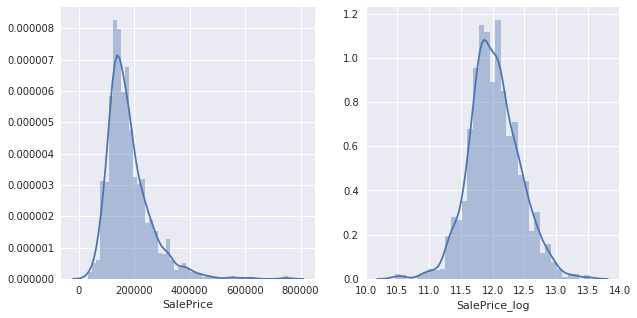

In [79]:
rcParams['figure.figsize'] = (10,5)
plt.subplot(1,2,1)
pp = sns.distplot(example['SalePrice'])

plt.subplot(1,2,2)
pp = sns.distplot(example['SalePrice_log'])
plt.show()

接下來，我們透過`偏態係數`，來檢驗資料分佈是否屬於`偏態分佈`，此指標能夠確認資料分佈是否對稱。
$$
SK = \frac{3(\bar{X}-X_{med})}{\sigma}
$$
其中，$\bar{X}$為平均數，$X_med$為中位數，$\sigma$為標準差。

$SK>0$表示右偏(正偏)，$SK<0$表示左偏(負偏)。

In [80]:
numerical_alldata = [col for col in alldata.columns if alldata[col].dtype != 'O']

In [81]:
from scipy.stats import skew
skew_indx = alldata.skew(axis=0).sort_values(ascending=False)
print(skew_indx.head(10))

MiscVal          21.950962
PoolArea         17.697766
LotArea          13.116240
LowQualFinSF     12.090757
Heating          12.080783
3SsnPorch        11.377932
LandSlope         4.975813
KitchenAbvGr      4.302763
BsmtFinSF2        4.146636
EnclosedPorch     4.004404
dtype: float64


偏態係數沒有一個絕對範圍，大於`0.5`時我們就可以稱分佈過於`右偏`，反之，小於`-0.5`就是`左偏`。

In [82]:
skew_indx = skew_indx[abs(skew_indx) > 0.75]
skew_indx = skew_indx.index
alldata[skew_indx] = np.log1p(alldata[skew_indx])

### 將剩下欄位使用`One-hot encoding`表示

In [83]:
alldata = pd.get_dummies(alldata)

####  因為在train data上去除了2個離群值，所以剩餘1458筆

In [84]:
X_train = alldata[:1458]
X_test = alldata[1458:]
y_train = y
y_train = np.log1p(y_train) # 將預測值SalePrice取對數，讓特徵與預測值相關性提高

In [85]:
print('X_train.shape: ',X_train.shape)
print('X_test.shape: ',X_test.shape)
print('y_train.shape: ',y_train.shape)

X_train.shape:  (1458, 211)
X_test.shape:  (1459, 211)
y_train.shape:  (1458,)


## 建模 

我們已經完成了特徵工程的部分，接下來就是建模，我挑出了幾個在效率以及表現上兼備的迴歸模型。

* `Ridge Regression`：能夠調整 $\alpha$ 係數，當 $\alpha$ 越大，對於影響較小的特徵係數給予越小的權重，達到正則化效果。
* `Lasso Regression`：能夠調整 $\alpha$ 係數，當 $\alpha$ 越大，對於影響較小的特徵係數給予收縮至 $0$ ，捨棄該特徵，達到正則化效果。
* `Elastic Net Regression`: 同時調整`L1`正則項與`L2`正則項的係數，而`alpha`參數能同時調整`L1`與`L2`，而`l1_ratio`則是平衡`L1`與`L2`的權重係數，`l1_ratio`越大，`L1`正則化效果越強，`L2`正則化效果越小。
* `SVM Regression`：常用的`kernel`有三種，`linear,polynomial,rbf`，其中這三個`kernel`有共同的懲罰項係數`C`可以調整，`C`越大正則化效果越強，而其中`polynomial,rbf`分別有`degree,rbf`參數可以調整，`polynomial`是透過次方項係數`degree`將線性不可分的特徵映射至線性可分，`degree`越大越容易`overfitting`，而`rbf`是透過`gamma`來調整，其思想是以泰勒展開式能夠表示任何連續可微`n`次多項式來逼近最佳迴歸線，`gamma`越大越容易`overfitting`。
* `KernelRidge`: 這個方法將`kernel`的概念套用到`Ridge regression`上，直觀的想法是先使用`kernel`參數對數據進行映射成線性可分`(poly)`或是超平面`(rbf)`上，在使用`Ridge regression`進行預測。

---

我們總結一下目前為止的步驟

   1. 在一開始資料探索，我們檢查了所有資料的缺失值 `NaN`，並透過[說明文件](https://ww2.amstat.org/publications/jse/v19n3/decock/datadocumentation.txt)來處理替換。
   2. 檢查所有欄位評級，在評價上有優劣關係的欄位，使用`LabelEncoder`轉成數值型態。
   3. 接下來，有些欄位可以互相結合成為一個新的特徵。
   4. 針對連續型態及離散型態的欄位畫圖，去除離群值。
   5. 為了符合迴歸基本`常態`假設，我們針對`偏態係數`大於0.75的欄位以及`SalePrice`進行對數轉換。
   6. 其餘沒有優劣關係的非數值型態的欄位，我們將其使用`One-hot encoding`來轉換。
   
接下來，我們使用對數轉換過的預測值`SalePrice`訓練得到模型之後，最後在`testing data`上得到的最終預測值需要使用指數 $e$ 轉換回去。

---

現在要比較哪一種迴歸方法搭配哪一種係數的效果最好，我們使用`5-fold`的`cross-validation`，能夠幫助我們遍歷數據。

In [86]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR, LinearSVR # LinearSVR與使用kernal為linear的SVR是等價的
from sklearn.linear_model import ElasticNet, BayesianRidge
from sklearn.kernel_ridge import KernelRidge

### 首先定義我們的rmse函數

因為kaggle競賽上的評價函數為`Root_mean_squared_error`，所以我們也使用`rmse`，還有其他評價函數請見[網址](http://scikit-learn.org/stable/modules/model_evaluation.html)

$$
RMSE=\sqrt{\frac{\sum_{i=1}^N(y_{pred}-y_{true})^2}{N}}
$$

在`sklearn.model_selection`中有一個很方便的函數，叫做`cross_val_score`，能夠設定`cv`參數來得到每次在`validation set`上的測試結果，若`cv`為5，就代表做`5-fold`的`cross-validation`，並得到5次`validation set`的分數。

In [87]:
def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

### Base Line

這裏表示每個迴歸模型在預設參數上的表現。

我們能夠發現表現不錯的模型為`LinearRegression,Ridge,Lasso,Ela,Bay`，在此基準上進行更多得參數調整。

In [88]:
models = [LinearRegression(),Ridge(),Lasso(alpha=0.01,max_iter=10000),SVR(),LinearSVR(),
          ElasticNet(alpha=0.001,max_iter=10000),BayesianRidge(),
          KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)]

names = ['LR', 'Ridge', 'Lasso', 'SVR', 'LinSVR', 'Ela','Bay','Ker']
for name, model in zip(names, models):
    score = rmse_cv(model, X_train, y_train)
    print('{}: {:.6f}, {:.4f}'.format(name,score.mean(),score.std()))

LR: 0.125231, 0.0086
Ridge: 0.120126, 0.0078
Lasso: 0.148532, 0.0034
SVR: 0.386831, 0.0152
LinSVR: 0.198797, 0.0241
Ela: 0.114957, 0.0074
Bay: 0.117237, 0.0068
Ker: 0.166609, 0.0083


### 建立一個函數，能夠依照所有參數值進行訓練

In [89]:
class grid():
    def __init__(self,model):
        self.model = model
    
    def grid_get(self,X,y,param_grid):
        # 設定greedy search參數，能夠依照param_dict的預設值進行訓練，評價函數為mse
        grid_search = GridSearchCV(self.model,param_grid,cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X,y)
        print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
        grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])

## Lasso

In [30]:
grid(Lasso()).grid_get(X_train,y_train,{'alpha': [0.0004,0.0005,0.0007,0.0009],'max_iter':[10000]})

{'max_iter': 10000, 'alpha': 0.0004} 0.11496020729375381
                                 params  mean_test_score  std_test_score
0  {'max_iter': 10000, 'alpha': 0.0004}         0.114960        0.001744
1  {'max_iter': 10000, 'alpha': 0.0005}         0.115012        0.001741
2  {'max_iter': 10000, 'alpha': 0.0007}         0.115595        0.001721
3  {'max_iter': 10000, 'alpha': 0.0009}         0.116557        0.001696


## Ridge

In [31]:
grid(Ridge()).grid_get(X_train,y_train,{'alpha':[0.001,0.1,1,10,35,40,45,50,55,60,65,70,80,90]})

{'alpha': 10} 0.11751119477271375
              params  mean_test_score  std_test_score
0   {'alpha': 0.001}         0.125520        0.002188
1     {'alpha': 0.1}         0.124472        0.002124
2       {'alpha': 1}         0.120387        0.001892
3      {'alpha': 10}         0.117511        0.001495
4      {'alpha': 35}         0.121263        0.001352
5      {'alpha': 40}         0.121960        0.001337
6      {'alpha': 45}         0.122616        0.001323
7      {'alpha': 50}         0.123233        0.001310
8      {'alpha': 55}         0.123815        0.001297
9      {'alpha': 60}         0.124364        0.001285
10     {'alpha': 65}         0.124883        0.001273
11     {'alpha': 70}         0.125375        0.001262
12     {'alpha': 80}         0.126288        0.001240
13     {'alpha': 90}         0.127118        0.001219


## SVR with rbf kernel

In [32]:
grid(SVR()).grid_get(X_train,y_train,{'C':[5,7,11,13,15],'kernel':["rbf"],'gamma':[0.0003,0.0004],'epsilon':[0.008,0.009]})

{'kernel': 'rbf', 'epsilon': 0.009, 'C': 5, 'gamma': 0.0003} 0.2767976099802994
                                               params  mean_test_score  \
0   {'kernel': 'rbf', 'epsilon': 0.008, 'C': 5, 'g...         0.276837   
1   {'kernel': 'rbf', 'epsilon': 0.008, 'C': 5, 'g...         0.284660   
2   {'kernel': 'rbf', 'epsilon': 0.009, 'C': 5, 'g...         0.276798   
3   {'kernel': 'rbf', 'epsilon': 0.009, 'C': 5, 'g...         0.284633   
4   {'kernel': 'rbf', 'epsilon': 0.008, 'C': 7, 'g...         0.277013   
5   {'kernel': 'rbf', 'epsilon': 0.008, 'C': 7, 'g...         0.284709   
6   {'kernel': 'rbf', 'epsilon': 0.009, 'C': 7, 'g...         0.276966   
7   {'kernel': 'rbf', 'epsilon': 0.009, 'C': 7, 'g...         0.284681   
8   {'kernel': 'rbf', 'epsilon': 0.008, 'C': 11, '...         0.277089   
9   {'kernel': 'rbf', 'epsilon': 0.008, 'C': 11, '...         0.284729   
10  {'kernel': 'rbf', 'epsilon': 0.009, 'C': 11, '...         0.277031   
11  {'kernel': 'rbf', 'epsilon':

## KernelRidge

In [36]:
param_dict={'alpha':[0.2,0.3,0.4], 'kernel':["polynomial"], 'degree':[1,2],'coef0':[0.8,1]}
grid(KernelRidge()).grid_get(X_train,y_train,param_grid=param_dict)

{'kernel': 'polynomial', 'degree': 1, 'coef0': 1, 'alpha': 0.2} 0.1279845676707635
                                               params  mean_test_score  \
0   {'kernel': 'polynomial', 'degree': 1, 'coef0':...         0.128768   
1   {'kernel': 'polynomial', 'degree': 2, 'coef0':...         0.186478   
2   {'kernel': 'polynomial', 'degree': 1, 'coef0':...         0.127985   
3   {'kernel': 'polynomial', 'degree': 2, 'coef0':...         0.185948   
4   {'kernel': 'polynomial', 'degree': 1, 'coef0':...         0.132731   
5   {'kernel': 'polynomial', 'degree': 2, 'coef0':...         0.179775   
6   {'kernel': 'polynomial', 'degree': 1, 'coef0':...         0.131964   
7   {'kernel': 'polynomial', 'degree': 2, 'coef0':...         0.179280   
8   {'kernel': 'polynomial', 'degree': 1, 'coef0':...         0.135786   
9   {'kernel': 'polynomial', 'degree': 2, 'coef0':...         0.175347   
10  {'kernel': 'polynomial', 'degree': 1, 'coef0':...         0.135047   
11  {'kernel': 'polynomial', 

## Elastic Net

In [38]:
grid(ElasticNet()).grid_get(X_train,y_train,{'alpha':[0.0008,0.001,0.004,0.005],'l1_ratio':[0.08,0.1,0.3],'max_iter':[10000]})

{'max_iter': 10000, 'l1_ratio': 0.3, 'alpha': 0.001} 0.1151438848929302
                                               params  mean_test_score  \
0   {'max_iter': 10000, 'l1_ratio': 0.08, 'alpha':...         0.118175   
1   {'max_iter': 10000, 'l1_ratio': 0.1, 'alpha': ...         0.117698   
2   {'max_iter': 10000, 'l1_ratio': 0.3, 'alpha': ...         0.115478   
3   {'max_iter': 10000, 'l1_ratio': 0.08, 'alpha':...         0.117456   
4   {'max_iter': 10000, 'l1_ratio': 0.1, 'alpha': ...         0.116942   
5   {'max_iter': 10000, 'l1_ratio': 0.3, 'alpha': ...         0.115144   
6   {'max_iter': 10000, 'l1_ratio': 0.08, 'alpha':...         0.115866   
7   {'max_iter': 10000, 'l1_ratio': 0.1, 'alpha': ...         0.116058   
8   {'max_iter': 10000, 'l1_ratio': 0.3, 'alpha': ...         0.120558   
9   {'max_iter': 10000, 'l1_ratio': 0.08, 'alpha':...         0.116403   
10  {'max_iter': 10000, 'l1_ratio': 0.1, 'alpha': ...         0.116799   
11  {'max_iter': 10000, 'l1_ratio': 0.3,

## Predict

現在我們得到`Lasso`搭配`alpha=0.0004`可以在訓練集上得到最好的結果。

In [40]:
model = Lasso(alpha=0.0004,max_iter=10000)
model.fit(X_train, y_train)

Lasso(alpha=0.0004, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [46]:
predict = np.expm1(model.predict(X_test))

## Submission

In [57]:
testid = pd.read_csv('all/test.csv')['Id']
result = pd.DataFrame({'Id':testid,'SalePrice':predict})
result.to_csv('submission.csv',index=False)

[s](score.png)

### 對數轉換-還原範例：

In [44]:
x = np.log1p(3) # log(1+x)
x

1.3862943611198906

In [45]:
np.expm1(x) # exp(x)-1

3.0